In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.mlab   as mlab

from matplotlib import rc
from sklearn.metrics import pairwise_distances

from scipy.spatial.distance import cdist
from scipy.special import expit
from scipy.stats import bernoulli
from numpy.polynomial.polynomial import polyval

from scipy.optimize import minimize
from scipy.stats import norm, laplace

from sklearn.model_selection import GridSearchCV
from sklearn.kernel_ridge import KernelRidge

import functools

%matplotlib inline

## Data Generation

In [2]:
# set the random seed
random.seed(123)

In [3]:
# generate data from the marginal distributions P(X_0) and P(X_1)
ns = 500
d  = 5
X0 = np.random.randn(ns,d)
X1 = np.random.laplace(0,0.2,size=(ns,d))

In [4]:
# generate Y_0 and Y_1 from the conditional models
b = 1.0
beta_vec  = np.array([0.1,0.2,0.3,0.4,0.5])
Y0 = np.dot(beta_vec,X0.T) + 0.1*np.random.randn(X0.shape[0])      # potential outcome Y_0
Y1 = np.dot(beta_vec,X1.T) + b + 0.1*np.random.randn(X1.shape[0])  # potential outcome Y_1

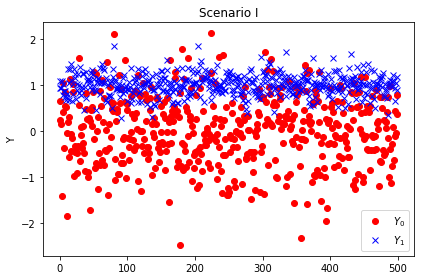

In [5]:
# plot the true functions and the samples
fig, ax = plt.subplots(1,1)

ax.plot(Y0,linewidth=1,linestyle="None",marker='o',color='red',label="Y_0")
ax.plot(Y1,linewidth=1,linestyle="None",marker='x',color='blue',label="Y_1")
ax.legend(["$Y_0$","$Y_1$"])
ax.set_title(r"Scenario I")
ax.set_ylabel(r"Y")
fig.tight_layout()

In [6]:
# save the figure
fig.savefig('cf_data.pdf',dpi=100)

/Users/krikamol/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/krikamol/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  after removing the cwd from sys.path.
/Users/krikamol/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  import sys


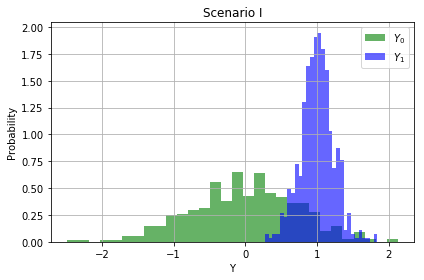

In [7]:
# plot the histograms
fig, ax = plt.subplots(1,1)
n, bins, patches = ax.hist(Y0,30,normed=1,facecolor='green', alpha=0.6, label="$Y_0$")
y0 = mlab.normpdf(bins, 0, 1)

n, bins, patches = ax.hist(Y1,30,normed=1,facecolor='blue', alpha=0.6,label="$Y_1$")
y1 = mlab.normpdf(bins, 2, 1)

ax.legend()
ax.set_title(r"Scenario I")
ax.set_ylabel(r"Probability")
ax.set_xlabel(r"Y")
ax.grid(True)

fig.tight_layout();

In [8]:
# save the figure
fig.savefig('cf_data_hist.pdf',dpi=100)

## Construct Counterfactual Mean Embedding

In [9]:
# kernel function
def gauss_rbf(X1,X2,sigma=1):
    """
    The Gaussian RBF kernel function.
    X1 : the first nxd input data matrix. Each row corresponds to data point
    X2 : the second mxd input data matrix. Each row corresponds to the data point
    """
    
    K = np.exp(-np.divide(cdist(X1,X2,'sqeuclidean'),2*sigma))
    
    return K
###

In [10]:
def find_best_params(X1,Y1,reg_grid=[1e1,1e0, 0.1, 1e-2, 1e-3,1e-4,1e-5],
                     gamma_grid=np.logspace(-2, 2, 10), num_cv=5):

    kr = GridSearchCV(KernelRidge(kernel='rbf', gamma=0.1), cv=num_cv,
                  param_grid={"alpha": reg_grid,
                              "gamma": gamma_grid})
    kr.fit(X1, Y1)
    
    sg = 1.0/kr.get_params()['estimator__gamma']
    reg_param = kr.get_params()['estimator__alpha']

    return sg,reg_param

In [13]:
def estimate_cme(X0,X1,Y1):

    sg,reg_param = find_best_params(X1,Y1)
    
    K1 = gauss_rbf(X1,X1,sg)
    K2 = gauss_rbf(X1,X0,sg)

    # beta vector
    #b = np.dot(np.dot(np.linalg.inv(K1 + ns*reg_param*np.eye(ns)),K2),np.ones((ns,1))/ns)
    b = np.dot(np.dot(np.linalg.inv(K1 + reg_param*np.eye(ns)),K2),np.ones((ns,1))/ns)
    
    return b

In [14]:
b = estimate_cme(X0,X1,Y1)
print(sum(b))

[0.81123331]


## Kernel Herding

In [15]:
Yt = np.linspace(-2,2,100)
Yt = Yt[:,np.newaxis]
YY0 = Y0[:,np.newaxis] # Y

sg = np.median(pairwise_distances(YY0,Yt,metric='euclidean'))**2

In [16]:
# simplify kernel function to avoid dimension crashing
def rbf_kernel(X1,X2,sigma=1):
    
    K = np.exp(-((X1 - X2)**2)/(2*sigma))
    return K

# minimization problem in each step
def obj_fun_herding(y, b, yt_hist=None, t=None):
    first_term  = np.dot(b.T,rbf_kernel(YY0,y,sg))
    if yt_hist is None:
        return -first_term
    else:
        second_term = (1.0/(t+1))*rbf_kernel(yt_hist,y,sg).sum()
    return -first_term + second_term

# the MMD objective
def mmd_obj(ys,yt,bs,sigma): 
    mvec = np.repeat(1.0/len(yt),len(yt))
    first_term = np.dot(np.dot(mvec.T,gauss_rbf(yt,yt,sigma)),mvec)
    second_term = np.dot(np.dot(bs.T,gauss_rbf(ys,yt,sigma)),mvec)
    third_term = np.dot(np.dot(bs.T,gauss_rbf(ys,ys,sigma)),bs)
    
    return first_term - 2*second_term + third_term
    
    
def generate_herding_samples(num_herding,Y0,sigma,weights):
    # first iteration
    obj_fn = functools.partial(obj_fun_herding, b=weights, yt_hist=None, t=None)
    y0 = Y0.mean(axis=0)
    res = minimize(obj_fn, y0, method='CG', options={'gtol': 1e-10, 'disp': False})
    yt = res.x.ravel()[0]

    # initialize samples
    yt_samples = [yt]
    obj_val = [mmd_obj(Y0,np.array(yt_samples)[:,np.newaxis],weights,sigma).flatten()]

    # start the iterations 2 to num_herding
    max_trials = 10
    for t in range(2, num_herding+1):
        yt_hist = np.array(yt_samples)
        obj_fn = functools.partial(obj_fun_herding, b=weights,yt_hist=yt_hist, t=t)
        res = minimize(obj_fn, y0, method='CG', options={'gtol': 1e-10, 'disp': False})
    
        num_trials = 0 
        while (not res.success and num_trials < max_trials):
            res = minimize(obj_fn, y0 + 1e-5*np.random.randn(), method='CG', options={'gtol': 1e-10, 'disp': False})
            num_trials += 1
        
        yt = res.x.ravel()[0]
        yt_samples += [yt]
        obj_val += [mmd_obj(YY0,np.array(yt_samples)[:,np.newaxis],weights,sigma).flatten()]
    
    return [yt_samples,obj_val]

In [17]:
# sample size
m = 200
sg = np.median(pairwise_distances(YY0,metric='euclidean'))**2
[yt_samples,obj_val] = generate_herding_samples(m,YY0,sg,b)

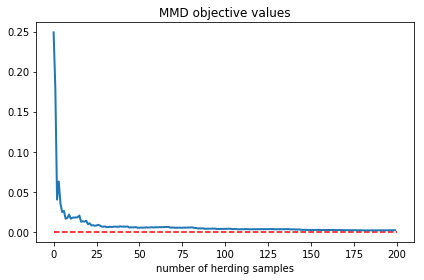

In [18]:
# plot the histograms
fig, ax = plt.subplots(1,1)
ax.plot(range(m),obj_val,linewidth=2)

ax.set_title("MMD objective values")
ax.set_xlabel("number of herding samples")
ax.hlines(0.0, 0, m, colors='r', linestyles='dashed')

fig.tight_layout();

In [19]:
# save the figure
fig.savefig('cf_mmd_objective.pdf', dpi=100)

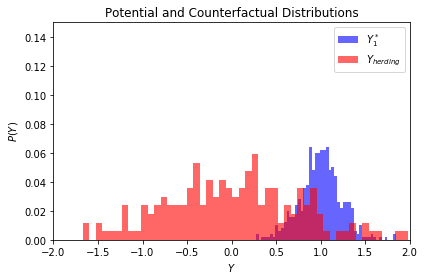

In [20]:
yt_samples = [y for y in yt_samples if y > -2 and y < 2]

# plot the histograms
fig, ax = plt.subplots(1,1)
#n, bins, patches = ax.hist(Y0, 50, weights=np.ones_like(Y0) / len(Y0), facecolor='green', alpha=0.6, label="$Y^*_0$")
n, bins, patches = ax.hist(Y1, 50, weights=np.ones_like(Y1) / len(Y1), facecolor='blue', alpha=0.6, label="$Y^*_1$")
n, bins, patches = ax.hist(yt_samples, 50, weights=np.ones_like(yt_samples) / len(yt_samples), facecolor='red', alpha=0.6, label="$Y_{herding}$")

ax.legend()
ax.set_title("Potential and Counterfactual Distributions")
ax.set_xlabel("$Y$")
ax.set_ylabel("$P(Y)$")
ax.axes.set_xlim((-2, 2))
ax.axes.set_ylim((0.0,0.15))

fig.tight_layout();

In [21]:
# save the figure
fig.savefig('cf_distributions_herding.pdf', dpi=100)

# Multiple Experiments with Testing

We evaluate the test power as the sample size increases

In [22]:
num_experiments = 1000

# generate data from the marginal distributions P(X_0) and P(X_1)
NS = [50,100,150,200,250,300]
d  = 5
noise_var = 0.1

# generate Y_0 and Y_1 from the conditional models
beta_vec  = np.array([0.1,0.2,0.3,0.4,0.5])
alpha_vec = np.array([0.5,0.4,0.3,0.2,0.1])
alpha_0   = 0.05

significance_level = 0.01

In [ ]:
test_powers = np.zeros((2,len(NS)))

for i in range(len(NS)):
    
    ns = NS[i]
    lin_num_rejects = 0
    rbf_num_rejects = 0
    
    for n in range(num_experiments):
    
        ### generate data 
        X  = np.random.randn(ns,d)
        Prob_vec = expit(np.dot(alpha_vec,X.T) + alpha_0)

        T  = bernoulli.rvs(Prob_vec)
        Z  = bernoulli.rvs(0.5,size=len(T[T==1]))

        X0 = X[T==0,:]
        X1 = X[T==1,:]
        Y1 = np.dot(beta_vec,X[T==1,:].T) + noise_var*np.random.randn(X[T==1,:].shape[0])
    
        ### calculate the test statistics and p-value
        YY1 = Y1[:,np.newaxis]

        sigma2 = np.median(pairwise_distances(YY0, metric='euclidean'))**2
    
        ### estimate the CME and generate sample using kernel herding
        weights = estimate_cme(X0,X1,Y1)
        Y0,_ = generate_herding_samples(ns,YY1,sigma2,weights)
        YY0 = Y0[:,np.newaxis]
    
        # Gaussian RBF kernel
        mmd2u_rbf, mmd2u_null_rbf, p_value_rbf = kernel_two_sample_test(YY0, YY1,
                                                        kernel_function='rbf',
                                                        gamma=1.0/sigma2,
                                                        verbose=False)
    
        rbf_num_rejects += int(p_value_rbf < significance_level)
    
        # linear kernel
        mmd2u_lin, mmd2u_null_lin, p_value_lin = kernel_two_sample_test(YY0, YY1,
                                                        kernel_function='linear',
                                                        verbose=False)
    
        lin_num_rejects += int(p_value_lin < significance_level)
    
    # calculate the test powers
    test_powers[0,i] = lin_num_rejects/num_experiments
    test_powers[1,i] = rbf_num_rejects/num_experiments